# Quantization of block DWT-ransformed audio signals

In [1]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

## Capture an audio sequence

In [155]:
def plot(y, xlabel='', ylabel='', title='', marker='.'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, num=len(y))
    ax.plot(x, y, marker, markersize=1)
    plt.show(block=False)

In [156]:
fs = 44100
duration = 80000/44100  # seconds
signal = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")
signal = signal.flatten()

Say something!
done


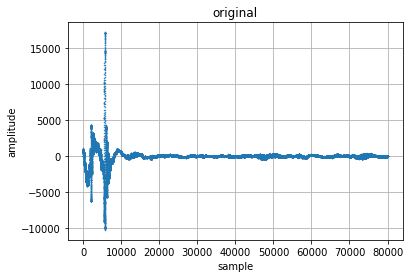

In [157]:
plot(signal, "sample", "amplitude", "original")

## Select a number of levels of the DWT

In [158]:
levels = 3

## Filters selection

In [175]:
#wavelet_name = "haar"
#wavelet_name = "db5"
wavelet_name = "db11"
#wavelet_name = "db20"
#wavelet_name = "bior2.2"
#wavelet_name = "bior3.5"
#wavelet_name = "rbio2.2"
wavelet = pywt.Wavelet(wavelet_name)
#mode = "zero"
mode = "per"

## Define a dead-zone quantizer

In [176]:
def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

## Extract 3 consecutive chunks from the audio sequence

In [177]:
chunk_size = 128
chunk_number = 15
left_chunk = signal[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
center_chunk = signal[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
right_chunk = signal[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
chunks = np.concatenate([left_chunk, center_chunk, right_chunk])

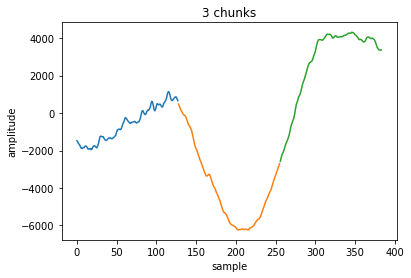

In [178]:
#plot(chunks, "sample", "amplitude", "3 consecutive chunks", '-')
pylab.plot(np.linspace(0, len(left_chunk)-1, len(left_chunk)), left_chunk)
pylab.plot(np.linspace(len(left_chunk), len(left_chunk) + len(center_chunk) - 1, len(center_chunk)), center_chunk)
pylab.plot(np.linspace(len(left_chunk) + len(center_chunk), len(left_chunk) + len(center_chunk) + len(right_chunk) - 1, len(right_chunk)), right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("3 chunks")
pylab.show()

In [179]:
128*3

384

In [180]:
len(chunks)

384

## Quantize the chunks in the DWT domain
Each chunk is transformed independently.

In [181]:
quantization_step = 128

def transform_and_quantize(chunk):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=levels, mode=mode)
    quantized_decomposition = []
    for subband in decomposition:
        quantized_subband = deadzone_quantizer(subband, quantization_step)
        quantized_decomposition.append(quantized_subband)
    return quantized_decomposition
    #coefficients, slices = pywt.coeffs_to_array(decomposition)
    #quantization_indexes = deadzone_quantizer(coefficients, quantization_step)
    #return quantization_indexes
    
def dequantize_and_detransform(decomposition):
#def dequantize_and_detransform(quantization_indexes):
    dequantized_decomposition = []
    for subband in decomposition:
        dequantized_subband = deadzone_dequantizer(subband, quantization_step)
        dequantized_decomposition.append(dequantized_subband)
    chunk = pywt.waverec(dequantized_decomposition, wavelet=wavelet, mode=mode)
    return chunk
    #zeros = np.empty_like(quantization_indexes)
    #_ = pywt.wavedec(zeros, wavelet=wavelet, level=levels, mode=mode)
    #_, slices = pywt.coeffs_to_array(_)
    #quantized_coeffs = deadzone_dequantizer(quantization_indexes, quantization_step)
    #decomposition = pywt.array_to_coeffs(quantized_coeffs, slices, output_format="wavedec")
    #reconstructed_chunk = pywt.waverec(decomposition, wavelet=wavelet, mode=mode)
    #return reconstructed_chunk

def process_chunk(chunk):
    quantization_indexes = transform_and_quantize(chunk)
    reconstructed_chunk = dequantize_and_detransform(quantization_indexes)
    return reconstructed_chunk
    
reconstructed_left_chunk = process_chunk(left_chunk)
reconstructed_center_chunk = process_chunk(center_chunk)
reconstructed_right_chunk = process_chunk(right_chunk)

/home/vruiz/.local/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


## Concatenation of the non overlaped reconstructed chunks

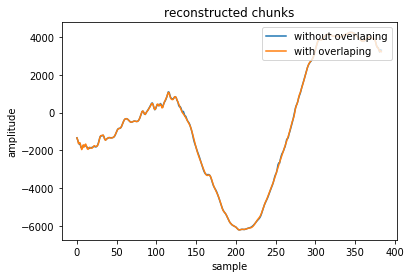

In [182]:
reconstructed_chunks = np.concatenate([reconstructed_left_chunk, reconstructed_center_chunk, reconstructed_right_chunk])
ideal_reconstruction = process_chunk(chunks)
pylab.plot(np.linspace(0, len(reconstructed_chunks)-1, len(reconstructed_chunks)), reconstructed_chunks, label = "without overlaping")
pylab.plot(np.linspace(0, len(ideal_reconstruction)-1, len(ideal_reconstruction)), ideal_reconstruction, label = "with overlaping")
pylab.legend(loc='upper right')
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed chunks")
pylab.show()

Signal discontinuities usually happen between chunks :-/

## A solution: use the neighbor samples between chunks
```
+------------+--------------+-------------+
| left_chunk | center_chunk | right_chunk |
+------------+--------------+-------------+
           OO OOOOOOOOOOOOOO OO
           -- oooooooooooooo ++

Compute the DWT of the O samples.
Transmit the o coefficients
Coefficients . must be used to reconstruct the center_chunk.
```

In [183]:
number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
print("number_of_overlaped_samples =", number_of_overlaped_samples)

number_of_overlaped_samples = 128


### Create `OO OOOOOOOOOOOOOO OO` (extended chunk)

number of samples overlaped with the previous chunk = 128
number of samples in the current chunk = 128
number of samples overlaped with the next chunk = 128
length of the extended chunk = 384


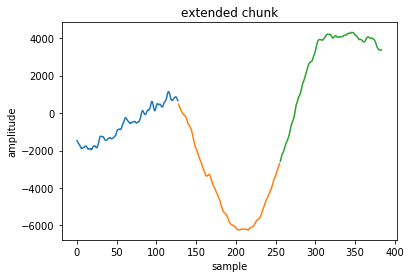

In [184]:
last_samples_left_chunk = left_chunk[chunk_size - number_of_overlaped_samples :]
first_samples_right_chunk = right_chunk[: number_of_overlaped_samples]
extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])
print("number of samples overlaped with the previous chunk =", len(last_samples_left_chunk))
print("number of samples in the current chunk =", len(center_chunk))
print("number of samples overlaped with the next chunk =", len(first_samples_right_chunk))
print("length of the extended chunk =", len(extended_chunk))
#plot(extended_chunk, "sample", "amplitude", "extended chunk", '-')
pylab.plot(np.linspace(0,
                       len(last_samples_left_chunk)-1,
                       len(last_samples_left_chunk)),
           last_samples_left_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) - 1,
                       len(center_chunk)),
           center_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk) + len(center_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) + len(first_samples_right_chunk) - 1,
                       len(first_samples_right_chunk)),
           first_samples_right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("extended chunk")
pylab.show()

### Reconstruction of the extended chunk

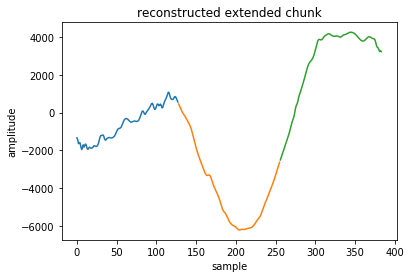

In [185]:
reconstructed_extended_chunk = process_chunk(extended_chunk)
#plot(reconstructed_extended_chunk, "sample", "amplitude", "reconstructed extended chunk", '-')
reconstructed_last_samples_left_chunk = reconstructed_extended_chunk[0:number_of_overlaped_samples]
reconstructed_center_chunk = reconstructed_extended_chunk[number_of_overlaped_samples:chunk_size + number_of_overlaped_samples]
reconstructed_first_samples_right_chunk = reconstructed_extended_chunk[chunk_size + number_of_overlaped_samples:]
pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed extended chunk")
pylab.show()

Let's explore how to reconstruct the center chunk without boundary distortion.

* Option 1: Use all the coefficients of the extended chunks.

    Are the coefficients resulting of the overlaped areas the same when are used by the two neighbor chunks? If this is true, we only need to transmit the coefficients of the non overlaped areas.

* Option 2: Suppose that the coefficients resulting of the overlaped areas are cero and we add the overlaped areas.

### Let's start transmitting only the central coefficients of each decomposition
supposing that the coefficients generated by the overlaped areas are cero, and adding the overlaped reconstructed areas.

In [186]:
def extract(decomposition):
    nos = number_of_overlaped_samples
    extracted_decomposition = [None]*len(decomposition)
    for subband_index in range(len(decomposition)-1, 0, -1):
        nos >>= 1
        extracted_decomposition[subband_index] = decomposition[subband_index][nos:len(decomposition[subband_index])-nos]
        #print(nos, len(decomposition[subband_index])-nos)
        print(len(extracted_decomposition[subband_index]))
    extracted_decomposition[0] = decomposition[0][nos:len(decomposition[0])-nos]
    return extracted_decomposition

In [187]:
extended_chunk_decomposition = transform_and_quantize(extended_chunk)
extraction_extended_chunk_decomposition = extract(extended_chunk_decomposition)

64
32
16


In [188]:
len(extraction_extended_chunk_decomposition[3])

64

In [189]:
reconstruction_extraction_extended_chunk_decomposition = dequantize_and_detransform(extraction_extended_chunk_decomposition)

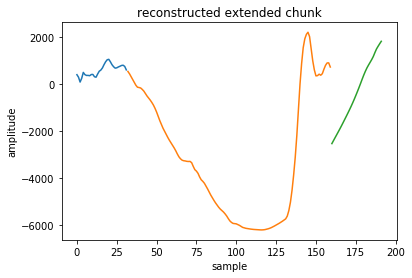

In [174]:
pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstruction_extraction_extended_chunk_decomposition) - 1,
                       len(reconstruction_extraction_extended_chunk_decomposition)),
           reconstruction_extraction_extended_chunk_decomposition)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed extended chunk")
pylab.show()

In this experiment we reconstruct 3 chunks

The idea is to transmit only the central section of the subbands of the current chunk and extract from the adjacent decomposed chunks those coefficients that has been ignored before the transmission.

The non transmitted coefficients should be provided by the adjacent decomposed chunks. Let's see if these coefficients are available in the adjacent decompossed chunks. If so, 

In [ ]:
central

### Reconstruction of the center chunk with boundary distortion

In [ ]:
central_coeffs = extended_chunk[number_of_overlaped_samples: -number_of_overlaped_samples]
recons_central_coeffs = process_chunk(central_coeffs)
plot(recons_central_coeffs, "sample", "amplitude", "reconstructed extended chunk", '-')

### What happens is we reconstruct the chunk using only the central coefficients?

### Compute `-- oooooooooooooo ++`

In [ ]:
extended_coefs = transform_and_quantize(extended_chunk)

### Compute `++` coeficients using right_chunk and the right part of center_chunk

In [ ]:
last_samples_center_chunk = center_chunk[chunk_size - number_of_overlaped_samples :]
extended_right_chunk = np.concatenate([last_samples_center_chunk, right_chunk])
plusplus_coefs = transform_and_quantize(extended_right_chunk)

### Supossing that the exterior coeffs are zero

In [ ]:
zeroed_extended_chunk = np.concatenate(
    [np.zeros(number_of_overlaped_samples),
    extended_chunk[number_of_overlaped_samples: -number_of_overlaped_samples],
    np.zeros(number_of_overlaped_samples)]
)
recons_zeroed_extended_chunk = process_chunk(zeroed_extended_chunk)[number_of_overlaped_samples: -number_of_overlaped_samples]
plot(recons_zeroed_extended_chunk, "sample", "amplitude", "reconstructed extended chunk", '-')

### The transformed and quantized (non extended) chunk (without overlaping)

In [ ]:
plot(rchunk_center, "sample", "amplitude", "reconstructed chunk without overlaping", '-')

### We check  overlaped coeffs